# Feed forward networks - universal approximation theorem

This goal of this notebook is to demonstrate the universal approximation theorem for feed forward neural networks. We will use a synthetic data set generated from the non-linear function $f(x) = 0.1 x^3 - x^2 + x + 1$, after only a few epochs of training the neural network should closely approximate this function with a piece-wise linear function.

For a nice visual proof and discussion of the universal approximation theorem please refer to this youtube video: [Universal Approximation with Deep Narrow Networks](https://www.youtube.com/watch?v=6-SORkCLYPM)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# setting the random seed - DON'T CHANGE THIS
np.random.seed(0)

### Generate the synthetic data set

In [8]:
# Define the target function f(x) = x^3 + x^2 - x - 1
# [TODO]: feel free to modify the target function as you see fit
def target_function(x):
    return 0.1 * x**3 - x**2 + x + 1

# Generate 1000 training examples in the range [-10, 10]
# [TODO]: feel free to modify the number of training examples and see if the accuracy of the model improves or not.
n_samples = 1000
x_train = np.random.uniform(-5.0, 10.0, n_samples)
# wrap the training data in a torch tensor for training on the GPU
x_train = torch.tensor(x_train, dtype=torch.get_default_dtype())
y_train = target_function(x_train)

### Define the architecture of your model

In [9]:
# DO NOT MODIFY THIS CLASS DEFINITION
class MLP(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(MLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Instantiating the MLP
# TODO: feel free to modify the width and depth of the network
hidden_size = 64  # width of the hidden layers
num_layers = 2    # depth of the network
model = MLP(hidden_size=hidden_size, num_layers=num_layers)

### Define the loss function and optimizer

In [10]:
# for regression tasks we usually use mean squared error
loss_fn = nn.MSELoss()
# Adam is a more sophisticated version of gradient descent, that implements momentum and second order (Newtonian) moments
# It works well for most tasks and is the de facto optimizer for neural networks
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training loop

The inner training loop is structed as follows:
- Sample a batch of data from the dataset.
- Evaluate the model for this batch of data to get the predictions.
- Compute the loss of the predictions with respect to the ground truth labels.
- Backpropagate the gradients through the model.
- Update the parameters of the network in the negative direction of the gradients (minimize). 

We repeat this until all the data in the dataset has been seen, this corresponds to one epoch of training. We can run training for many epochs until we see the training loss converge. 

In [11]:
# hyperparameters
# TODO: feel free to play around with the hyperparameters;
# How does the batch size affect learning? 
# How many epochs do we need for the model be accurate?
batch_size = 64
n_epochs = 1000

for epoch in range(n_epochs):
    # shuffle the dataset
    indices = torch.randperm(n_samples)
    x_train_shuffled = x_train[indices]
    y_train_shuffled = y_train[indices]
    
    # iterate over the batches
    for i in range(0, n_samples, batch_size):
        
        # create batches of the training data
        x_batch = x_train_shuffled[i:i+batch_size].unsqueeze(1)
        y_batch = y_train_shuffled[i:i+batch_size].unsqueeze(1)
        
        # forward pass
        y_pred = model(x_batch)  # predictions from the model
        
        # compute the loss
        loss = loss_fn(y_pred, y_batch)
        
        # backpropagate the loss
        optimizer.zero_grad() # first we zero any gradients from the previous iteration
        loss.backward() # backpropagate 
        
        # update the parameters of the MLP
        optimizer.step()
        
    # print loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}")


Epoch [100/1000], Loss: 0.1137
Epoch [200/1000], Loss: 0.0135
Epoch [300/1000], Loss: 0.0055
Epoch [400/1000], Loss: 0.0018
Epoch [500/1000], Loss: 0.0063
Epoch [600/1000], Loss: 0.0098
Epoch [700/1000], Loss: 0.0015
Epoch [800/1000], Loss: 0.0036
Epoch [900/1000], Loss: 0.0127
Epoch [1000/1000], Loss: 0.0097


### Evaluating the model

Now we will evaluate the model by making predictions at 10 equally spaced points in the range $[-5, 10]$. This will help us visualize the piecewise linear function learned by the MLP.

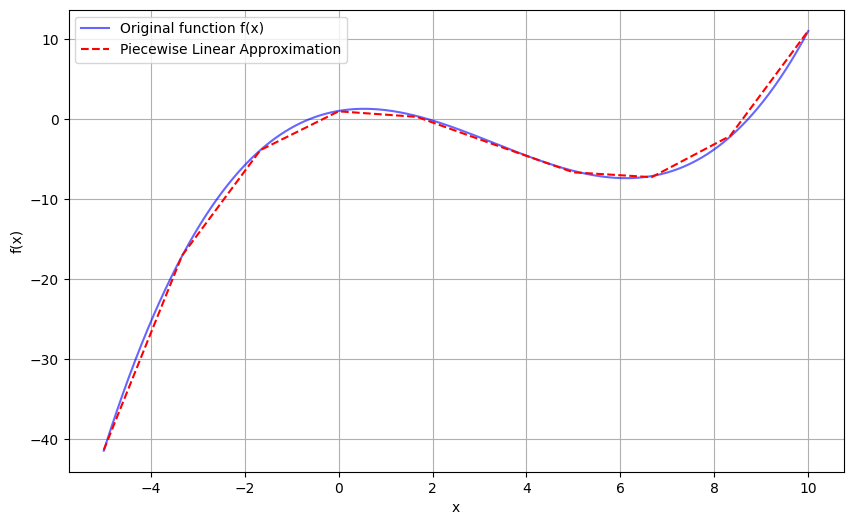

In [12]:
# 10 equally spaced points
x_eval = torch.linspace(-5, 10, 10).unsqueeze(1)
# this turns of any gradient computations - we don't need to compute the gradients when evaluating the model
with torch.no_grad():
    y_eval = model(x_eval)  # predictions from the trained model
    
# take the predictions off the GPU and convert to numpy arrays
x_piecewise = x_eval.numpy()
y_piecewise = y_eval.numpy()

# evlaute the ground truth function
x_truth = np.linspace(-5, 10, 1000)
y_truth = target_function(x_truth)

plt.figure(figsize=(10, 6))
plt.plot(x_truth, y_truth, label="Original function f(x)", color='blue', alpha=0.6)
plt.plot(x_piecewise, y_piecewise, label="Piecewise Linear Approximation", color='red', linestyle='--')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid()
plt.show()